In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import os
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import torch
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules import dropout
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from os import path
import sys
from torch.utils.data import Dataset
from torch.utils.data import WeightedRandomSampler
from sklearn.preprocessing import StandardScaler
import random
from collections import defaultdict

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tsai

In [4]:
from tsai.all import *

In [3]:
flag_cuda = torch.cuda.is_available()
torch.manual_seed(42)
np.random.seed(42)
device= None 
if not flag_cuda:
    print('Using CPU')
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print('Using GPU')

Using GPU


# Datasplit generation

In [4]:
PATH = '/content/drive/MyDrive/ECE542_sp2022_Project_TerrainRecognition'
TEST_PATH = PATH+ "/TestData/"
PATH = PATH +'/TrainingData/'
val_subject = 6
# test_subject = 8

In [5]:
files = []
for filename in os.listdir(PATH):
    files.append(filename)
files = sorted(files, key = lambda x: (int(x.split('_')[1]),int(x.split('_')[2]), x.split('_')[4] ))
files_train = list(filter(lambda x: int(x.split('_')[1]) not in  [val_subject], files))
files_test = list(filter(lambda x: int(x.split('_')[1]) == val_subject, files))
# files_test = list(filter(lambda x: int(x.split('_')[1])== test_subject, files))

In [6]:
files_train_y = files_train[3::4]
# files_train_y

In [7]:
files_y_val = pd.concat([pd.read_csv(PATH + i , header=None) for i in files_train_y])

In [8]:
continue_loop = True
threshold = 0.005
_, files_split_dist = np.unique(files_y_val, return_counts=True)
files_split_dist = np.divide(files_split_dist, np.max(files_split_dist))
while continue_loop:
  seed = random.randint(0, 2**32 - 1)
  random.seed(seed)
  np.random.seed(seed)
  # files_train_y_split_1 = random.sample(files_train_y, int(len(files_train_y) * 0.8))
  # files_train_y_split_1 = random.sample(files_train_y, int(len(files_train_y) * 0.8))
  indices = np.random.choice(len(files_train_y), int(len(files_train_y) * 0.8), replace=False)
  files_train_y_split_1 = [files_train_y[i] for i in indices]
  files_train_y_split_2 = [i for i in files_train_y if i not in files_train_y_split_1]
  files_split_1_val = pd.concat([pd.read_csv(PATH + i , header=None) for i in files_train_y_split_1])
  files_split_2_val = pd.concat([pd.read_csv(PATH + i , header=None) for i in files_train_y_split_2])
  _, files_split_1_dist = np.unique(files_split_1_val, return_counts=True)
  files_split_1_dist = np.divide(files_split_1_dist, np.max(files_split_1_dist))
  _, files_split_2_dist = np.unique(files_split_2_val, return_counts=True)
  files_split_2_dist = np.divide(files_split_2_dist, np.max(files_split_2_dist))
  if ((files_split_dist[0] - threshold <= files_split_1_dist[0] <= files_split_dist[0] + threshold) and
      (files_split_dist[1] - threshold <= files_split_1_dist[1] <= files_split_dist[1] + threshold) and
      (files_split_dist[2] - threshold <= files_split_1_dist[2] <= files_split_dist[2] + threshold) and
      (files_split_dist[3] - threshold <= files_split_1_dist[3] <= files_split_dist[3] + threshold) and
      (files_split_dist[0] - threshold <= files_split_2_dist[0] <= files_split_dist[0] + threshold) and
      (files_split_dist[1] - threshold <= files_split_2_dist[1] <= files_split_dist[1] + threshold) and
      (files_split_dist[2] - threshold <= files_split_2_dist[2] <= files_split_dist[2] + threshold) and
      (files_split_dist[3] - threshold <= files_split_2_dist[3] <= files_split_dist[3] + threshold)):
          print(files_split_1_dist, files_split_2_dist, files_split_dist)
          random_seed = seed
          break


[1.         0.05709291 0.07494683 0.2126912 ] [1.         0.05102839 0.07418481 0.20784589] [1.         0.05572816 0.07477534 0.21160081]


In [9]:
indices2 = np.random.choice(len(files_train_y), int(len(files_train_y) * 0.8), replace=False)
files_train_y_split_ex = [files_train_y[i] for i in indices]
sorted(files_train_y_split_1) == sorted(files_train_y_split_ex), seed

(True, 1423741814)

In [10]:
files_train_y_split_1_names = ["_".join(i.split("__")[: -1]) for i in files_train_y_split_1]
files_train_y_split_2_names = ["_".join(i.split("__")[: -1]) for i in files_train_y_split_2]

In [11]:
training_files = [i for i in files_train if "_".join(i.split("__")[: -1]) in files_train_y_split_1_names]
validation_files = [i for i in files_train if "_".join(i.split("__")[: -1]) in files_train_y_split_2_names]

# Dataset generation and training

In [18]:
def windows(d, w, t):
  r = np.arange(len(d))
  s = r[::t]
  z = list(zip(s, s + w))
  f = '{0[0]}:{0[1]}'.format
  g = lambda t: d.iloc[t[0]:t[1]]
  ranges = list(map(f,z))
  return ranges, pd.concat(map(g, z), keys=map(f, z))

In [12]:
def make_dataset(files, X, Y,  freq_down=True, window_size=60, overlap = 30, is_test = False):

    overlap = overlap
    if is_test:
        overlap = overlap * 2
    total_length = 0
    for i in range(0, len(files), 4):
        x_time, x, y_time, y = files[i: i + 4]
        train_df = None
        if freq_down:
            #X_features
            x_time_df = pd.read_csv(PATH + x_time , header=None)
            x_df = pd.read_csv(PATH + x , header=None)
            x_combined = pd.concat([x_time_df, x_df], axis=1, ignore_index=True)
            x_combined = x_combined.loc[range(1,len(x_combined), 4)].reset_index()  # down sampled the frequency

            #Y_labels
            y_time_df = pd.read_csv(PATH + y_time , header=None)
            y_df = pd.read_csv(PATH + y , header=None)
            y_combined = pd.concat([y_time_df, y_df], axis=1, ignore_index=True)

            train_df = pd.concat([x_combined, y_combined], axis=1, ignore_index=True)
            train_df = train_df.drop(columns=[0, 1, 8])  # Dropping the time stamp
            total_length += train_df.shape[0]
            ranges, windows_df = windows(train_df, window_size, overlap)
            for ran in ranges:
                l,r = ran.split(':')
                df_range = windows_df.iloc[int(l): int(r)]
                if int(r) > len(windows_df):
                    break
                y_values = df_range[9].values
                x_values = df_range.drop(columns=[9]).values
                X.append(x_values)
                Y.append(Counter(list(y_values)).most_common(1)[0][0])
        else:
            #X_features
            x_time_df = pd.read_csv(PATH + x_time, header=None)
            x_time_df.astype('float64')
            x_df = pd.read_csv(PATH + x, header=None)
            x_combined = pd.concat([x_time_df, x_df], axis=1, ignore_index=True)
            x_combined = x_combined.rename({0:'timestamp'}, axis='columns')
            x_combined.set_index('timestamp', inplace=True)

            #Y_labels
            y_time_df = pd.read_csv(PATH + y_time , header=None)
            y_time_df.astype('float64')
            y_df = pd.read_csv(PATH + y, header=None)
            y_combined = pd.concat([y_time_df, y_df], axis=1, ignore_index=True)
            y_combined = y_combined.rename({0:'timestamp'}, axis='columns')
            y_combined.set_index('timestamp', inplace=True)
            train_df = pd.merge_asof(left=x_combined, right=y_combined, left_index=True, right_index = True, direction='nearest')  # Merging using the nearest values
            total_length += train_df.shape[0]
            ranges, windows_df = windows(train_df, window_size, overlap)
            for ran in ranges:
                l,r = ran.split(':')
                df_range = windows_df.iloc[int(l): int(r)]
                if int(r) > len(windows_df):
                    break
                y_values = df_range['1_y'].values
                x_values = df_range.drop(columns=['1_y']).values
                X.append(x_values)
                Y.append(Counter(list(y_values)).most_common(1)[0][0])
    print(total_length, len(X), len(Y))
    return X, Y

In [13]:
def make_dataset_with_norm(files, X, Y, freq_down=True, window_size=60, overlap = 30, is_test = False, per_subject_norm=True, total_y = [], per_session_norm=False):

    total_length = 0
    subject_files = defaultdict(list)
    
    for i in range(1,9):
      temp_files = list(filter(lambda x: int(x.split('_')[1]) == i, files))
      subject_files[i].extend(temp_files)  # separating out all the files
    
    for key, value in subject_files.items():
      cur_sub_files = value
      total_train_df = pd.DataFrame()
      if len(cur_sub_files) == 0: # skip if no files
        continue
      
      for i in range(0, len(cur_sub_files), 4):
          x_time, x, y_time, y = cur_sub_files[i: i + 4]
          train_df = None
          if freq_down:
              #X_features
              x_time_df = pd.read_csv(PATH + x_time , header=None)
              x_df = pd.read_csv(PATH + x , header=None)
              x_combined = pd.concat([x_time_df, x_df], axis=1, ignore_index=True)
              x_combined = x_combined.loc[range(1,len(x_combined), 4)].reset_index()  # Down sampled the frequency

              #Y_labels
              y_time_df = pd.read_csv(PATH + y_time , header=None)
              y_df = pd.read_csv(PATH + y , header=None)
              y_combined = pd.concat([y_time_df, y_df], axis=1, ignore_index=True)

              train_df = pd.concat([x_combined, y_combined], axis=1, ignore_index=True)
              train_df = train_df.drop(columns=[0, 1, 8])  # Dropping the time stamp
              train_df = train_df.rename({2:'acc_x',3:'acc_y',4:'acc_z',5:'gy_x',6:'gy_y',7:'gy_z',9:'target'}, axis='columns')
              total_length += train_df.shape[0]
              if is_test:
                total_y.extend(list(y_df.values))
              if total_train_df.empty:
                total_train_df = train_df
              else:
                total_train_df = pd.concat([total_train_df, train_df], ignore_index = True)

          else:
              #X_features
              x_time_df = pd.read_csv(PATH + x_time, header=None)
              x_time_df.astype('float64')
              x_df = pd.read_csv(PATH + x, header=None)
              x_combined = pd.concat([x_time_df, x_df], axis=1, ignore_index=True)
              x_combined = x_combined.rename({0:'timestamp'}, axis='columns')
              x_combined.set_index('timestamp', inplace=True)

              #Y_labels
              y_time_df = pd.read_csv(PATH + y_time , header=None)
              y_time_df.astype('float64')
              y_df = pd.read_csv(PATH + y, header=None)
              y_combined = pd.concat([y_time_df, y_df], axis=1, ignore_index=True)
              y_combined = y_combined.rename({0:'timestamp'}, axis='columns')
              y_combined.set_index('timestamp', inplace=True)
              train_df = pd.merge_asof(left=x_combined, right=y_combined, left_index=True, right_index = True, direction='nearest')  # Merging using the nearest values
              train_df = train_df.rename({'1_x':'acc_x',2:'acc_y',3:'acc_z',4:'gy_x',5:'gy_y',6:'gy_z','1_y':'target'}, axis='columns')
              total_length += train_df.shape[0]

              if is_test:
                total_y.extend(list(train_df['target'].values))

              if per_session_norm:   # apply standard scalar to normalize session data
                labels = train_df['target']
                labels = pd.DataFrame({'target':labels.values})
                temp_df = train_df.drop(columns=['target'])
                scaled_features = StandardScaler().fit_transform(temp_df.values)
                scaled_features_df = pd.DataFrame(scaled_features, index=temp_df.index, columns=temp_df.columns)
                # print(key, scaled_features_df.shape, labels.shape)
                train_df = pd.concat([scaled_features_df.reset_index(drop=True),labels.reset_index(drop=True)], axis=1, ignore_index=True)
                # print(key, total_train_df.shape)
                train_df.columns = ['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z','target']
                
              if total_train_df.empty:
                total_train_df = train_df
              else:
                total_train_df = pd.concat([total_train_df, train_df], ignore_index = True)
      

      if per_subject_norm:   # after collating subject records, apply standard scalar to normalize subject data
        labels = total_train_df['target']
        labels = pd.DataFrame({'target':labels.values})
        temp_df = total_train_df.drop(columns=['target'])
        scaled_features = StandardScaler().fit_transform(temp_df.values)
        scaled_features_df = pd.DataFrame(scaled_features, index=temp_df.index, columns=temp_df.columns)
        # print(key, scaled_features_df.shape, labels.shape)
        total_train_df = pd.concat([scaled_features_df.reset_index(drop=True),labels.reset_index(drop=True)], axis=1, ignore_index=True)
        # print(key, total_train_df.shape)
        total_train_df.columns = ['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z','target']
     
      # print(total_train_df.describe())
      
      # ranges, windows_df = windows(total_train_df, window_size, overlap)
      # for ran in ranges:
      #     l,r = ran.split(':')
      #     df_range = windows_df.iloc[int(l): int(r)]
      #     if int(r) > len(windows_df):
      #         break
      #     y_values = df_range['target'].values
      #     x_values = df_range.drop(columns=['target']).values

      #     X.append(x_values)
          
      #     Y.append(Counter(list(y_values)).most_common(1)[0][0])
      addl_rows_df = pd.DataFrame(total_train_df[-window_size:])
      total_train_df =  pd.concat([total_train_df, addl_rows_df], ignore_index = True)
      for i in range(len(total_train_df) - window_size):
          df_range = total_train_df.iloc[i:i+window_size]
          
          y_values = df_range['target'].values
          x_values = df_range.drop(columns=['target']).values

          X.append(x_values)
          
          Y.append(Counter(list(y_values)).most_common(1)[0][0])
      
    print(total_length, len(X), len(Y), len(total_y))
    return X, Y, total_y

freq_down boolean flag can be used to flip between 10hz and 40 hz frequency

In [14]:
train_X, train_y = [], []
valid_X, valid_y = [], []
test_X, test_y, test_total_y = [], [], []
make_dataset_with_norm(training_files, train_X, train_y, freq_down=False, window_size=60, overlap=1, is_test=False, per_subject_norm=False,total_y=[],per_session_norm=True)
train_X, train_y = np.array(train_X, dtype="float32"), np.array(train_y,dtype="float32")
make_dataset_with_norm(validation_files, valid_X, valid_y, freq_down=False, window_size=60, overlap=60,is_test=False, per_subject_norm=False,total_y=[],per_session_norm=True)
valid_X, valid_y = np.array(valid_X, dtype="float32"),np.array(valid_y, dtype="float32")
make_dataset_with_norm(files_test, test_X, test_y, freq_down=False, window_size=60, overlap=60, is_test=True, per_subject_norm=False, total_y=test_total_y,per_session_norm=True)
test_X, test_y, test_total_y = np.array(test_X, dtype="float32"), np.array(test_y, dtype="float32"),np.array(test_total_y, dtype="float32")  # test_total_y is actual 40hz sample with no windows
print("Done splitting the data")

923097 923097 923097 0
265733 265733 265733 0
152816 152816 152816 152816
Done splitting the data


In [24]:
test_X_down, test_y_down, test_total_y_down = [], [], []
make_dataset_with_norm(files_test, test_X_down, test_y_down, freq_down=True, window_size=60, overlap=60, is_test=True, per_subject_norm=False, total_y=test_total_y_down,per_session_norm=True)
test_X_down, test_y_down, test_total_y_down = np.array([], dtype="float32"), np.array([], dtype="float32"),np.array(test_total_y_down, dtype="float32") # test_total_y is actual 10hz sample with no windows

38204 38204 38204 38204


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
valid_X = scaler.transform(valid_X.reshape(-1, valid_X.shape[-1])).reshape(valid_X.shape)
test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)

In [ ]:
# train_X = np.array(train_X)
print(test_X.shape)

(5093, 30, 6)


In [ ]:
np.unique(np.isnan(train_y))

array([False])

In [ ]:
test_X.shape, valid_X.shape, test_y.shape, valid_y.shape

((2546, 60, 6), (7394, 60, 6), (2546,), (7394,))

In [ ]:
train_y

array([0., 1., 2., 3.], dtype=float32)

Generating Weights of the training labels

In [27]:
weight  = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_y), y = train_y)
label_weights = {i:weight[i] for i in range(len(weight))}
# sample_weights = [round(weight[int(i)],2) for i in train_y]
# weight = torch.tensor(weight)
# weight = weight.cuda()

In [ ]:
np.unique(train_y), weight

(array([0., 1., 2., 3.], dtype=float32),
 tensor([0.3365, 5.0400, 4.7424, 1.6159], device='cuda:0', dtype=torch.float64))

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv1d(6,16,3)
    self.conv2 = nn.Conv1d(16,32,3)
    self.pool1 = nn.MaxPool1d(2,2)
    self.conv3 = nn.Conv1d(32,64,3)
    self.conv4 = nn.Conv1d(64,128,3)
    self.pool2 = nn.MaxPool1d(2,2)
    self.fc1 = nn.Linear(512, 120)
    self.fc2 = nn.Linear(120, 64)
    self.fc3 = nn.Linear(64,4)
    self.dropout1 = nn.Dropout(0.1)

  def forward(self, x):
    x = F.relu(self.conv1(x.permute(0,2,1)))
    x = self.pool1(F.relu(self.dropout1(self.conv2(x))))
    x = F.relu(self.conv3(x))
    x = self.pool2(F.relu(self.dropout1(self.conv4(x))))
    # print("1",x.shape)
    # x = x.view(-1,3456)
    x = torch.flatten(x,1)
    # print("2",x.shape)
    x = F.relu(self.dropout1(self.fc1(x)))
    x = F.relu(self.dropout1(self.fc2(x)))
    # print("3", x.shape)
    x = self.fc3(x)
    return x

model = Net()
if flag_cuda:
  model.cuda()

In [ ]:
class Net2(nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    self.conv1 = nn.Conv1d(6,16,3)
    self.conv2 = nn.Conv1d(16,32,3)
    self.pool1 = nn.AvgPool1d(2,2)
    self.conv3 = nn.Conv1d(32,64,3)
    self.conv4 = nn.Conv1d(64,128,3)
    self.pool2 = nn.MaxPool1d(2,2)
    self.fc1 = nn.Linear(1536, 120)
    self.fc2 = nn.Linear(120, 64)
    self.fc3 = nn.Linear(64,4)
    self.dropout1 = nn.Dropout(0.1)
    self.dropout2 = nn.Dropout(0.25)
    # self.batch_norm = nn.BatchNorm1d()

  def forward(self, x):
    x = F.relu(self.conv1(x.permute(0,2,1)))
    x = self.pool1(self.dropout2(F.relu(self.conv2(x))))
    # print("1",x.shape)
    x = F.relu(self.conv3(x))
    x = self.pool2(self.dropout1(F.relu(self.conv4(x))))
    x = torch.flatten(x,1)
    # print("2",x.shape)
    x = self.dropout1(F.relu(self.fc1(x)))
    # print("3", x.shape)
    x = self.dropout1(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x

model = Net2()
if flag_cuda:
  model.cuda()

In [16]:
class LSTM(nn.Module):
  def __init__(self):
    super(LSTM, self).__init__()
    self.lstm1 = nn.LSTM(6,60,1,batch_first=True, bidirectional=False)
    self.fc1 = nn.Linear(3600, 120)
    self.fc2 = nn.Linear(120, 64)
    self.fc3 = nn.Linear(64,4)
    self.dropout1 = nn.Dropout(0.1)
    self.dropout2 = nn.Dropout(0.25)
    self.dropout3 = nn.Dropout(0.2)
    self.batch_norm = nn.BatchNorm1d(60)


  def forward(self, x):
    x, self.hidden1 = self.lstm1(x)
    x = self.dropout2(self.batch_norm(F.relu(x).permute(0, 2, 1)))
    # x = self.dropout1(F.relu(x))
    # print("1", x.shape)
    # x = self.dropout3(F.relu(self.lstm3(x.permute(0, 2, 1))[0]))
    # print("3", x.shape)
    x = torch.flatten(x,1)
    x = self.dropout1(F.relu(self.fc1(x)))
    # print("3", x.shape)
    x = self.dropout1(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x

model = LSTM()
if flag_cuda:
  model.cuda()

In [25]:
class BiLSTM(nn.Module):
  def __init__(self):
    super(BiLSTM, self).__init__()
    self.lstm1 = nn.LSTM(6,60,2,batch_first=True, bidirectional=True)
    self.lstm2 =  nn.LSTM(120,60,2,batch_first=True,bidirectional=True)
    self.lstm3 =  nn.LSTM(120,60,2,batch_first=True,bidirectional=True)
    self.fc1 = nn.Linear(7200, 120)
    self.fc2 = nn.Linear(120, 64)
    self.fc3 = nn.Linear(64,4)
    self.dropout1 = nn.Dropout(0.1)
    self.dropout2 = nn.Dropout(0.25)
    self.dropout3 = nn.Dropout(0.2)
    self.batch_norm = nn.BatchNorm1d(120)


  def forward(self, x):
    x, self.hidden1 = self.lstm1(x)
    x = self.dropout3(self.batch_norm(F.relu(x).permute(0, 2, 1)))
    x = self.dropout1(self.batch_norm(F.relu(self.lstm2(x.permute(0, 2, 1))[0]).permute(0,2,1)))
    # print("1", x.shape)
    x = self.dropout3(F.relu(self.lstm3(x.permute(0, 2, 1))[0]))
    # print("3", x.shape)
    x = torch.flatten(x,1)
    x = self.dropout1(F.relu(self.fc1(x)))
    # print("3", x.shape)
    x = self.dropout1(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x

model = BiLSTM()
if flag_cuda:
  model.cuda()

In [ ]:
class BiLSTM4(nn.Module):
  def __init__(self):
    super(BiLSTM4, self).__init__()
    self.lstm1 = nn.LSTM(6,4,2,batch_first=True, bidirectional=True)
    self.lstm2 =  nn.LSTM(8,4,2,batch_first=True,bidirectional=True)
    self.lstm3 =  nn.LSTM(8,4,2,batch_first=True,bidirectional=True)
    self.fc1 = nn.Linear(32, 16)
    self.fc2 = nn.Linear(16, 8)
    self.fc3 = nn.Linear(8,4)
    self.dropout1 = nn.Dropout(0.1)
    self.dropout2 = nn.Dropout(0.25)
    self.dropout3 = nn.Dropout(0.2)
    self.batch_norm = nn.BatchNorm1d(8)


  def forward(self, x):
    x, self.hidden1 = self.lstm1(x)
    x = self.dropout3(self.batch_norm(F.relu(x).permute(0, 2, 1)))
    x = self.dropout1(self.batch_norm(F.relu(self.lstm2(x.permute(0, 2, 1))[0]).permute(0,2,1)))
    # print("1", x.shape)
    x = self.dropout3(F.relu(self.lstm3(x.permute(0, 2, 1))[0]))
    # print("3", x.shape)
    x = torch.flatten(x,1)
    x = self.dropout1(F.relu(self.fc1(x)))
    # print("3", x.shape)
    x = self.dropout1(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x

model = BiLSTM4()
if flag_cuda:
  model.cuda()

In [ ]:
class BiLSTM120(nn.Module):
  def __init__(self):
    super(BiLSTM120, self).__init__()
    self.lstm1 = nn.LSTM(6,120,2,batch_first=True, bidirectional=True)
    self.lstm2 =  nn.LSTM(240,120,2,batch_first=True,bidirectional=True)
    self.lstm3 =  nn.LSTM(240,120,2,batch_first=True,bidirectional=True)
    self.fc1 = nn.Linear(28800, 1024)
    self.fc2 = nn.Linear(1024, 64)
    self.fc3 = nn.Linear(64,4)
    self.dropout1 = nn.Dropout(0.1)
    self.dropout2 = nn.Dropout(0.25)
    self.dropout3 = nn.Dropout(0.2)
    self.batch_norm = nn.BatchNorm1d(240)


  def forward(self, x):
    x, self.hidden1 = self.lstm1(x)
    x = self.dropout3(self.batch_norm(F.relu(x).permute(0, 2, 1)))
    x = self.dropout1(self.batch_norm(F.relu(self.lstm2(x.permute(0, 2, 1))[0]).permute(0,2,1)))
    # print("1", x.shape)
    x = self.dropout3(F.relu(self.lstm3(x.permute(0, 2, 1))[0]))
    # print("3", x.shape)
    x = torch.flatten(x,1)
    x = self.dropout1(F.relu(self.fc1(x)))
    # print("3", x.shape)
    x = self.dropout1(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x

model = BiLSTM120()
if flag_cuda:
  model.cuda()


In [44]:
# Specifying the loss function
criterion = nn.CrossEntropyLoss(weight = weight.float())

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#@title Imbalance in train_y
variable_name = ""
plt.style.use('seaborn')
plt.figure(figsize=(8,6),dpi=100)
text = ["standing / walking", "going downstairs","going upstairs", "walking on grass"]
labels = list(dict(Counter(train_y)).values())
for bar in range(0,4):
    plt.bar(text[bar],labels[bar])

In [ ]:
#@title Imbalance in train_y
plt.figure(figsize=(8,6),dpi=100)
plt.style.use('seaborn')
text = ["standing / walking", "going downstairs","going upstairs", "walking on grass"]
labels = list(dict(Counter(valid_y)).values())
for bar in range(0,4):
    plt.bar(text[bar],labels[bar])

In [ ]:
weighted_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [34]:
class TerrainDataset(Dataset):
  def __init__(self, data, target):
    self.data = np.array(data)
    self.target = np.array(target)
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index):
    return self.data[index], self.target[index]


In [45]:
batch_size = 60
train_dataset = TerrainDataset(train_X, train_y)
# x_train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = batch_size, sampler=weighted_sampler) # with weighted sampler
x_train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = batch_size, shuffle=True)
# y_train_loader = torch.utils.data.DataLoader(train_y,batch_size = batch_size, sampler=weighted_sampler) # with weighted sampler
validation_dataset = TerrainDataset(valid_X, valid_y)
x_validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = batch_size, shuffle=False)
# y_validation_loader = torch.utils.data.DataLoader(valid_y, batch_size = batch_size)

test_dataset = TerrainDataset(test_X, test_y)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [ ]:
for data, target in x_train_loader:
  print(list(map(int, list(target))))
  break

[3, 0, 3, 1, 0, 1, 1, 3, 3, 3, 1, 2, 3, 3, 3, 2, 0, 2, 0, 1, 3, 0, 3, 1, 2, 0, 1, 1, 3, 3, 3, 1, 0, 0, 0, 0, 1, 3, 3, 3, 3, 1, 1, 2, 3, 1, 1, 0, 2, 3, 1, 1, 3, 2, 0, 0, 1, 3, 1, 1, 2, 3, 2, 0, 2, 3, 1, 2, 1, 2, 0, 2, 0, 0, 0, 0, 1, 2, 2, 3, 2, 2, 0, 3, 3, 0, 0, 2, 1, 2, 3, 0, 2, 0, 3, 3, 0, 0, 0, 3, 0, 3, 3, 1, 3, 2, 2, 1, 3, 0, 2, 0, 0, 2, 2, 3, 0, 0, 2, 0]


Training Loop

Epoch: 1 	Training Loss: 0.134346 	Validation Loss: 0.450605
Validation loss decreased (inf --> 0.450605).  Saving model ...
Epoch: 2 	Training Loss: 0.068561 	Validation Loss: 0.775281
Epoch: 3 	Training Loss: 0.051870 	Validation Loss: 0.708788
Epoch: 4 	Training Loss: 0.044457 	Validation Loss: 0.910695
Epoch: 5 	Training Loss: 0.040223 	Validation Loss: 0.780456
Epoch: 6 	Training Loss: 0.036107 	Validation Loss: 0.984776
Epoch: 7 	Training Loss: 0.034094 	Validation Loss: 1.258360
Epoch: 8 	Training Loss: 0.032788 	Validation Loss: 1.890317
Epoch: 9 	Training Loss: 0.030802 	Validation Loss: 1.329864
Epoch: 10 	Training Loss: 0.030555 	Validation Loss: 1.269083


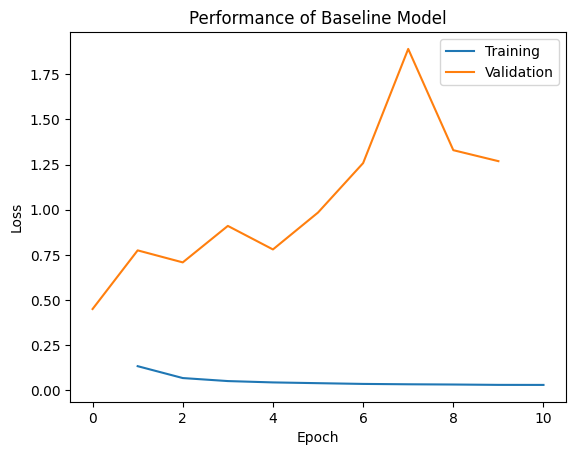

In [46]:
import matplotlib.pyplot as plt

n_epochs = 10 #50 #25

def trainNet(model,criterion,optimizer,n_epochs,flag_cuda):

  train_losslist = []
  valid_losslist = []
  valid_loss_min = np.Inf # track change in validation loss
  for epoch in range(1, n_epochs + 1):
      # Keeping track of training and validation loss
      train_loss = 0.0
      valid_loss = 0.0
    
      model.train()

      for data,target in x_train_loader:
          if flag_cuda:
              data, target = data.cuda(), target.cuda()
          optimizer.zero_grad()
          output = model(data)
          target = target.type(torch.LongTensor)
          if flag_cuda:
            output, target = output.cuda(), target.cuda()
          loss = criterion(output, target)
          # Backward pass: compute gradient of loss with respect to parameters
          loss.backward()
          # Perform a single optimization step (parameter update)
          optimizer.step()
          # Update training loss
          train_loss += loss.item()*data.size(0)
          
      model.eval()

      for data,target in x_validation_loader:
          if flag_cuda:
              data, target = data.cuda(), target.cuda()
          output = model(data)
          target = target.type(torch.LongTensor) 

          if flag_cuda:
            output, target = output.cuda(), target.cuda()

          loss = criterion(output, target)
          valid_loss += loss.item()*data.size(0)
      
      # Calculating average losses
      train_loss = train_loss/len(train_X)
      valid_loss = valid_loss/len(valid_X)
      train_losslist.append(train_loss)
      valid_losslist.append(valid_loss)
          
      #Printing training/validation statistics 
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, train_loss, valid_loss))
      
      # Saving model if validation loss has decreased
      if valid_loss < valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,valid_loss))
          torch.save(model.state_dict(), 'model.pt')
          valid_loss_min = valid_loss
        
  return train_losslist, valid_losslist

# Executing the training
train_losslist, valid_losslist = trainNet(model,criterion,optimizer,n_epochs,flag_cuda)

# Loading the best model
model.load_state_dict(torch.load('model.pt'))

# Plotting the learning curves
plt.plot(range(1, n_epochs + 1), train_losslist, valid_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Training','Validation'])
plt.title("Performance of Baseline Model")
plt.show()

In [47]:
classes = [0.,1.,2.,3.]
y_prediction = []

def assessNet(model,criterion, x_test_loader):
  # Tracking test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(4))
  class_total = list(0. for i in range(4))

  # Setting model to evaluate
  model.eval()

  # Iterating over batches of test data

  print(valid_X.shape)

  for data,target in x_test_loader:
      # Obtaining predictions and loss
      if flag_cuda:
          data, target = data.cuda(), target.cuda()
      output = model(data)
      # output = torch.argmax(output,dim = 1)
      target = target.type(torch.LongTensor) 
      if flag_cuda:
        output, target = output.cuda(), target.cuda()
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      # Comparing predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      # print(pred)
      y_prediction.extend(pred.cpu().numpy())
      correct = np.squeeze(correct_tensor.numpy()) if not flag_cuda else np.squeeze(correct_tensor.cpu().numpy())
      # Calculating test accuracy for each object class
      for i in range(len(output)):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  # Computing the average test loss
  test_loss = test_loss/len(valid_X)
  print('Test Loss: {:.6f}\n'.format(test_loss))
 
  # Computing the class accuracies
  for i in range(4):
      if class_total[i] > 0:
          print('Test Accuracy of %10s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %10s: N/A (no training examples)' % (classes[i]))

  # Computing the overall accuracy
  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))


  return

# model.load_state_dict(torch.load('model_0.89.pt'))

# assessNet(model,criterion, x_validation_loader)
assessNet(model,criterion, test_dataloader)

(260750, 60, 6)
Test Loss: 0.062218

Test Accuracy of        0.0: 96% (116928/121132)
Test Accuracy of        1.0: 97% (5691/5852)
Test Accuracy of        2.0: 99% (6793/6832)
Test Accuracy of        3.0: 92% (17669/19000)

Test Accuracy (Overall): 96% (147081/152816)


To predict the test dataset and replicate the window size and converting 40 hz freq to 10hz freq 

In [48]:
def get_classification(y_pred, y_actual,window_size,down_sampled=True):
  y_pred_total = []
  for i in range(0,len(y_pred),4):
      y_pred_total.extend([Counter(y_pred[i:i+4]).most_common(1)[0][0]])
  # for i in y_pred:
  #   # current_pred = [int(i)] * window_size
  #   if down_sampled:
  #     for i in range(0,len(current_pred),4):
  #       y_pred_total.extend([Counter(current_pred[i:i+4]).most_common(1)[0][0]])
  #   else:
  #     y_pred_total.extend([i]*window_size)

  print(len(y_pred_total), len(y_actual))
  
  len_pred = len(y_pred_total)
  len_actual = len(y_actual)

  # if len_actual > len_pred:
  #   diff = len_actual - len_pred
  #   y_pred_total.extend([y_pred_total[-1]]* diff)

  # elif len_pred > len_actual:
  #   y_pred_total = y_pred_total[:len_actual] 
  
  print(len(y_pred_total), len(y_actual))

  print(classification_report(y_true=y_actual, y_pred=y_pred_total))

get_classification(y_prediction, test_total_y_down, window_size=60, down_sampled=True)

38204 38204
38204 38204
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     30283
         1.0       0.82      0.88      0.85      1463
         2.0       0.74      0.94      0.83      1708
         3.0       0.90      0.92      0.91      4750

    accuracy                           0.95     38204
   macro avg       0.86      0.92      0.89     38204
weighted avg       0.95      0.95      0.95     38204



In [ ]:
cm = confusion_matrix(y_true=test_total_y, y_pred=y_pred_total)
cmd = ConfusionMatrixDisplay(cm, display_labels=["standing / walking", "going downstairs","going upstairs", "walking on grass"])
cmd.plot()

[Text(0, 0.5, 'standing / walking'),
 Text(0, 1.5, 'going downstairs'),
 Text(0, 2.5, 'going upstairs'),
 Text(0, 3.5, 'walking on grass')]

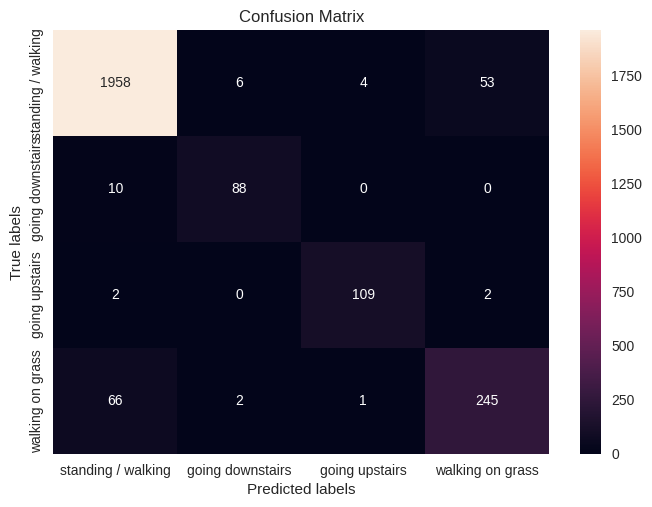

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(["standing / walking", "going downstairs","going upstairs", "walking on grass"]) 
ax.yaxis.set_ticklabels(["standing / walking", "going downstairs","going upstairs", "walking on grass"])

# Sensor data subject wise analysis

In [ ]:
import copy

In [ ]:
subject_stats = {'mean': [], 'min':[], 'max':[]}
actual_stats = {}

for i in range(6):  # 6 columns stats for all the subjects
  actual_stats[i] = copy.deepcopy(subject_stats)

for key, value in subject_files.items():
  local_files = value
  y_labels = []
  train_df = None
  for i in range(0, len(local_files), 4):
          x_time, x, y_time, y = local_files[i: i + 4]
          train_df = None
        
          #X_features
          x_time_df = pd.read_csv(PATH + x_time, header=None)
          x_time_df.astype('float64')
          x_df = pd.read_csv(PATH + x, header=None)
          x_combined = pd.concat([x_time_df, x_df], axis=1, ignore_index=True)
          x_combined = x_combined.rename({0:'timestamp'}, axis='columns')
          x_combined.set_index('timestamp', inplace=True)

          #Y_labels
          y_time_df = pd.read_csv(PATH + y_time , header=None)
          y_time_df.astype('float64')
          y_df = pd.read_csv(PATH + y, header=None)
          y_combined = pd.concat([y_time_df, y_df], axis=1, ignore_index=True)
          y_combined = y_combined.rename({0:'timestamp'}, axis='columns')
          y_combined.set_index('timestamp', inplace=True)
          train_df = pd.merge_asof(left=x_combined, right=y_combined, left_index=True, right_index = True, direction='nearest')  # Merging using the nearest values
          y_labels.extend(train_df['1_y'].values)
          train_df = train_df.drop(columns=['1_y'])
  
  for index, col in enumerate(train_df.columns[:6]):
    # print(train_df[col].mean())
    actual_stats[index]['mean'].append(train_df[col].mean())
    actual_stats[index]['min'].append(train_df[col].min())
    actual_stats[index]['max'].append(train_df[col].max())

  '''
  print(f"Subject {key} \n", train_df.columns[:6])     # Uncomment to plot the Class distribution for each subject
  print(key, len(y_labels))
  plt.style.use('seaborn')
  plt.figure(figsize=(8,6),dpi=100)
  plt.title(f"Subject {key} class distribution")
  text = ["standing / walking", "going downstairs","going upstairs", "walking on grass"]
  labels = list(dict(Counter(y_labels)).values())
  for bar in range(0,4):
      plt.bar(text[bar],labels[bar])
  '''

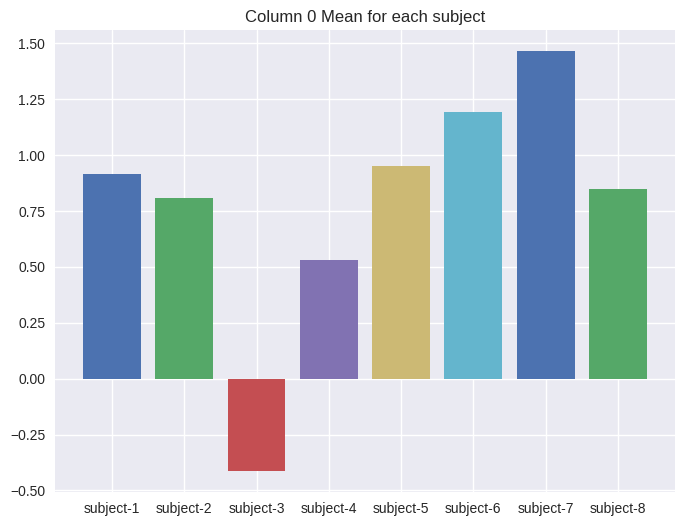

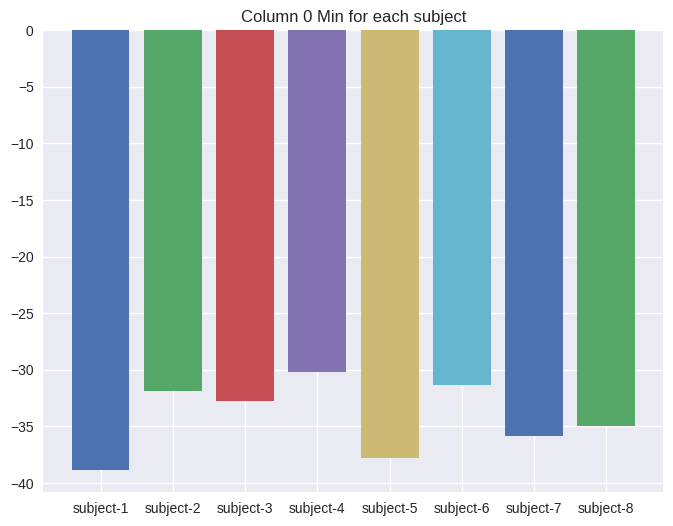

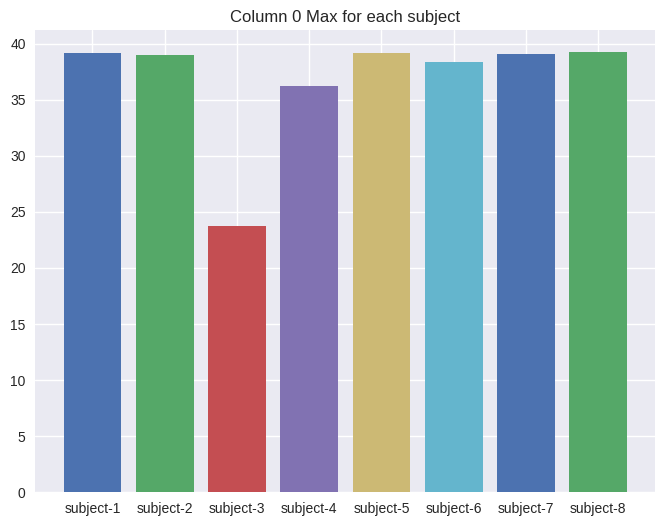

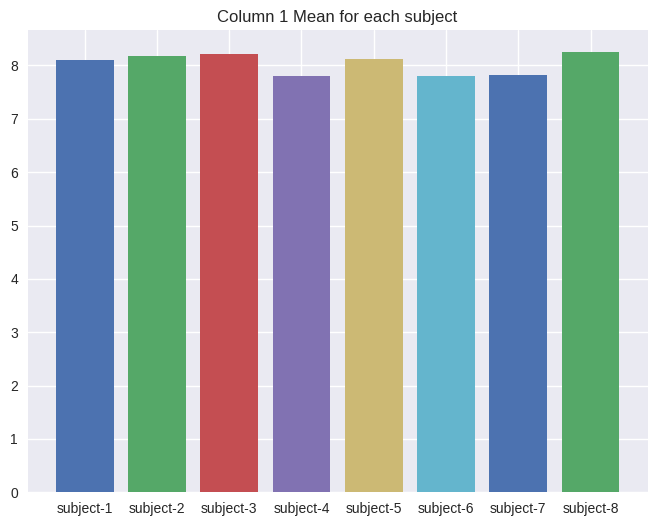

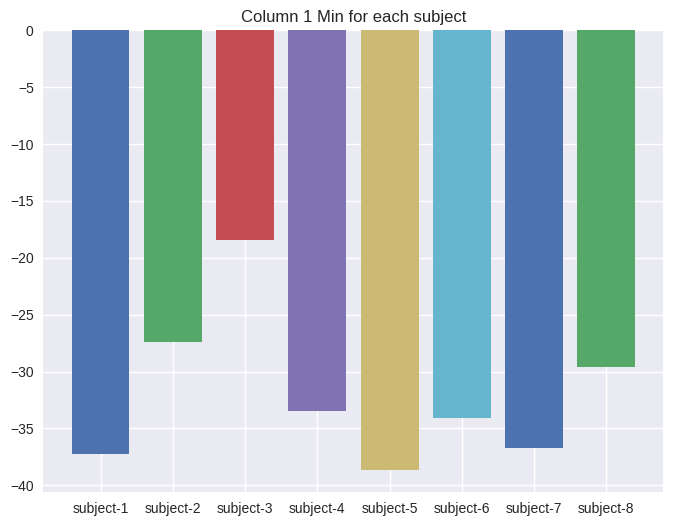

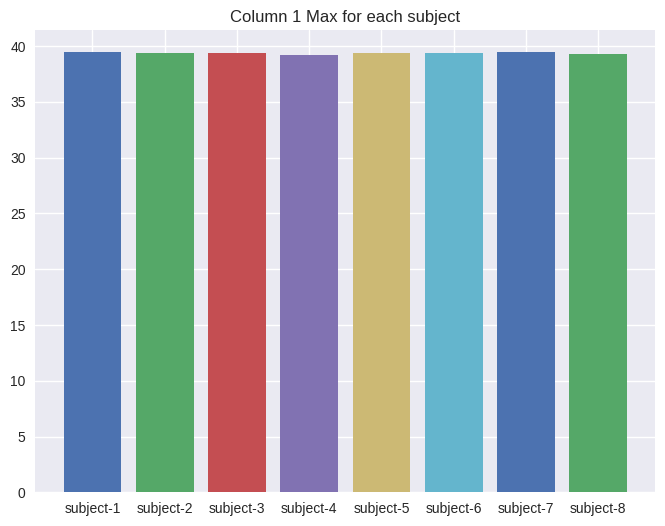

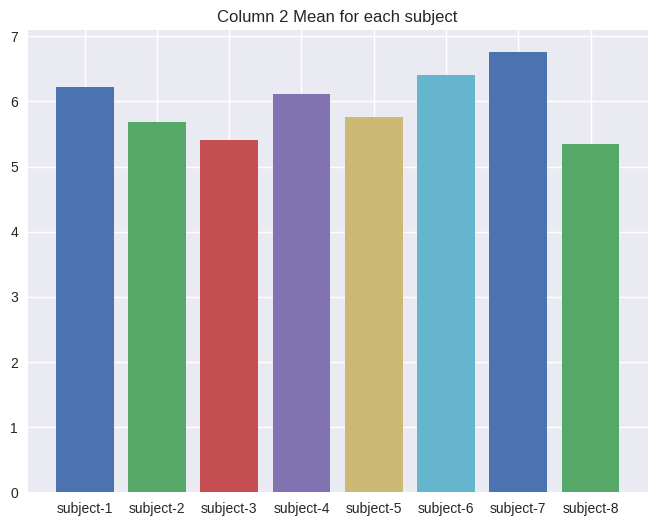

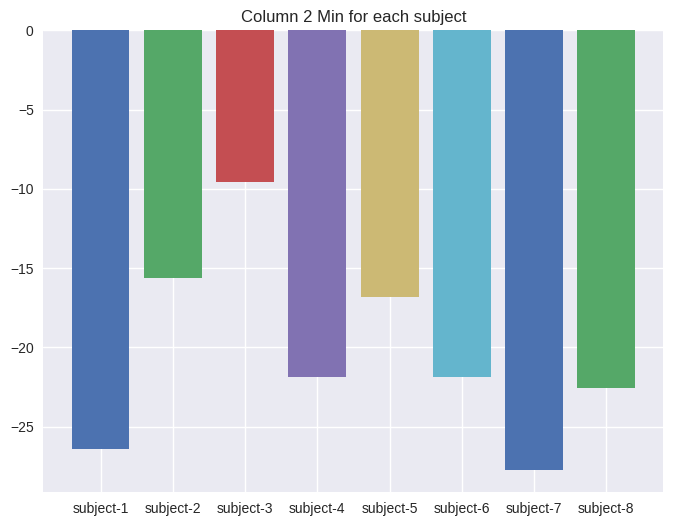

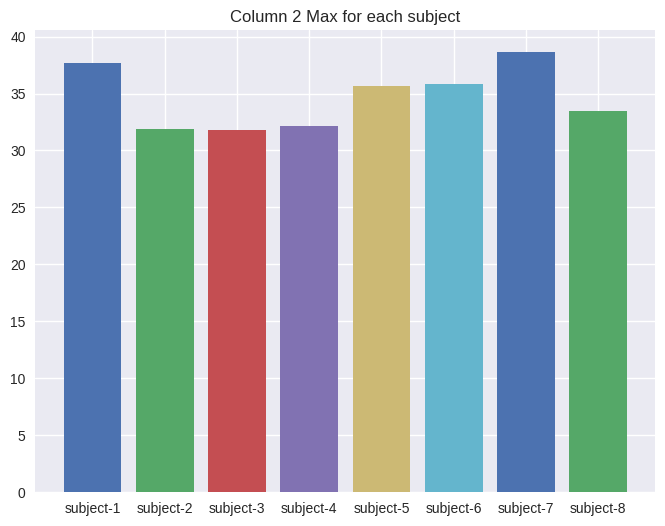

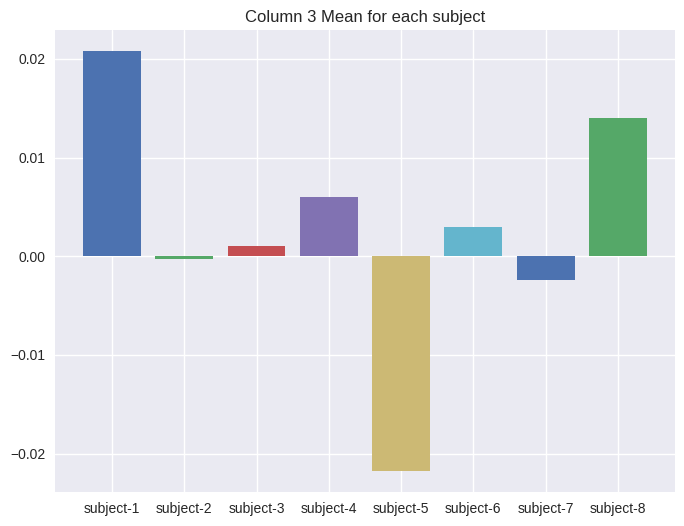

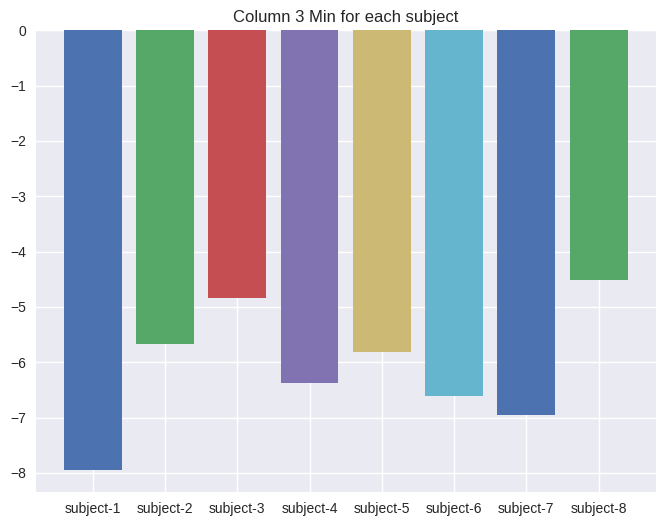

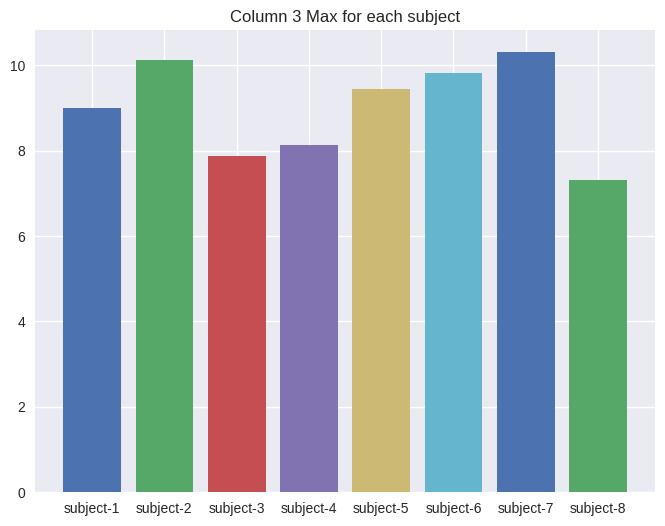

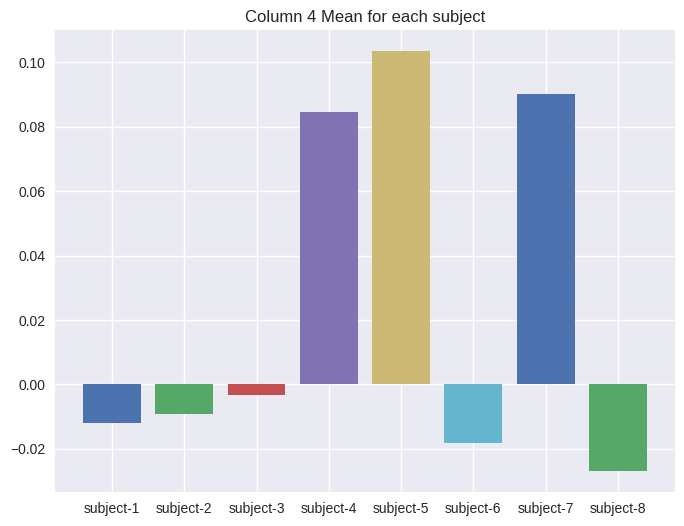

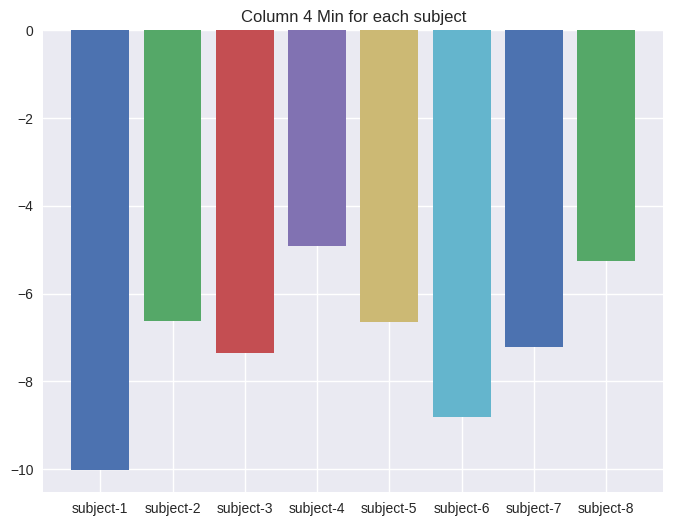

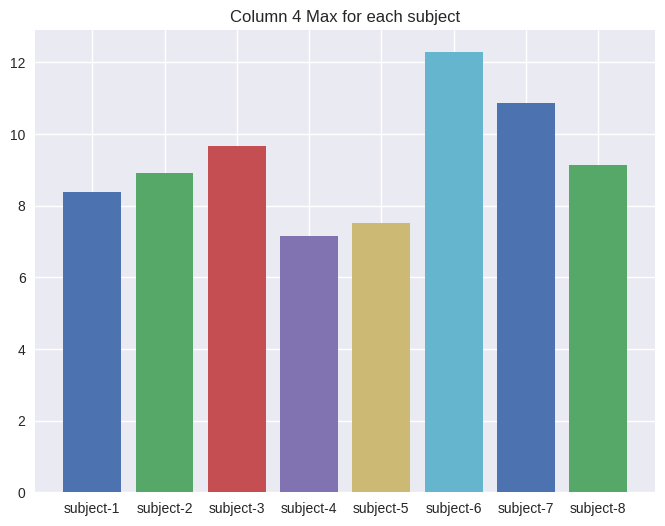

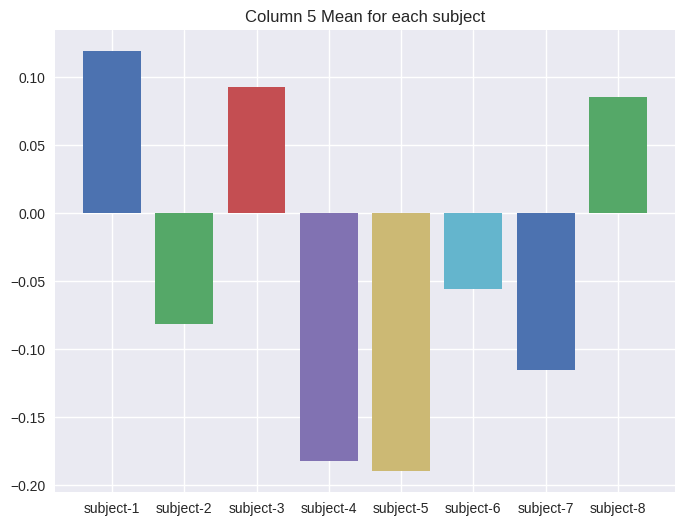

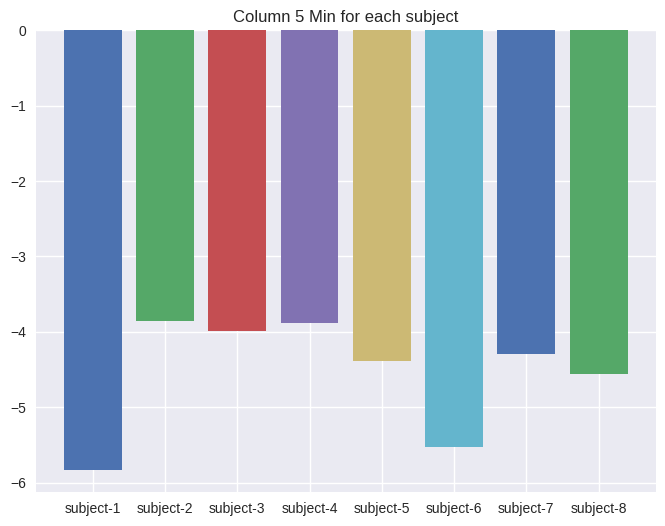

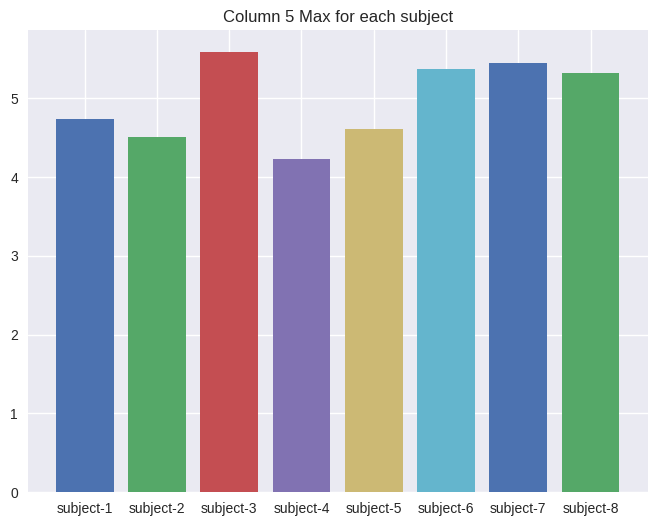

In [ ]:
for key, value in actual_stats.items():

  plt.style.use('seaborn')
  plt.figure(figsize=(8,6),dpi=100)
  plt.title(f"Column {key} Mean for each subject")
  text = [f'subject-{i}' for i in range(1,9)]
  stats = value['mean']
  for bar in range(8):
      plt.bar(text[bar],stats[bar])

  plt.style.use('seaborn')
  plt.figure(figsize=(8,6),dpi=100)
  plt.title(f"Column {key} Min for each subject")
  stats = value['min']
  for bar in range(8):
      plt.bar(text[bar],stats[bar])


  plt.style.use('seaborn')
  plt.figure(figsize=(8,6),dpi=100)
  plt.title(f"Column {key} Max for each subject")
  stats = value['max']
  for bar in range(8):
      plt.bar(text[bar],stats[bar])

# Others

In [ ]:
subject_files = defaultdict(list)
total_files = []
for filename in os.listdir(PATH):
    total_files.append(filename)
total_files = sorted(total_files, key = lambda x: (int(x.split('_')[1]),int(x.split('_')[2]), x.split('_')[4] ))
for i in range(1,9):
  files = list(filter(lambda x: int(x.split('_')[1]) == i, total_files))
  subject_files[i].extend(files)

In [ ]:
for key, value in subject_files.items():
  local_files = value
  y_labels = []
  for i in range(0, len(local_files), 4):
          x_time, x, y_time, y = local_files[i: i + 4]
          train_df = None
        
          #X_features
          x_time_df = pd.read_csv(PATH + x_time, header=None)
          x_time_df.astype('float64')
          x_df = pd.read_csv(PATH + x, header=None)
          x_combined = pd.concat([x_time_df, x_df], axis=1, ignore_index=True)
          x_combined = x_combined.rename({0:'timestamp'}, axis='columns')
          x_combined.set_index('timestamp', inplace=True)

          #Y_labels
          y_time_df = pd.read_csv(PATH + y_time , header=None)
          y_time_df.astype('float64')
          y_df = pd.read_csv(PATH + y, header=None)
          y_combined = pd.concat([y_time_df, y_df], axis=1, ignore_index=True)
          y_combined = y_combined.rename({0:'timestamp'}, axis='columns')
          y_combined.set_index('timestamp', inplace=True)
          train_df = pd.merge_asof(left=x_combined, right=y_combined, left_index=True, right_index = True, direction='nearest')  # Merging using the nearest values
          y_labels.extend(train_df['1_y'].values)
  print(key, len(y_labels))
  plt.style.use('seaborn')
  plt.figure(figsize=(8,6),dpi=100)
  plt.title(f"Subject {key} class distribution")
  text = ["standing / walking", "going downstairs","going upstairs", "walking on grass"]
  labels = list(dict(Counter(y_labels)).values())
  for bar in range(0,4):
      plt.bar(text[bar],labels[bar])

In [ ]:
subject_files[1][:10], subject_files[2][:10] 

(['subject_001_01__x_time.csv',
  'subject_001_01__x.csv',
  'subject_001_01__y_time.csv',
  'subject_001_01__y.csv',
  'subject_001_02__x_time.csv',
  'subject_001_02__x.csv',
  'subject_001_02__y_time.csv',
  'subject_001_02__y.csv',
  'subject_001_03__x_time.csv',
  'subject_001_03__x.csv'],
 ['subject_002_01__x_time.csv',
  'subject_002_01__x.csv',
  'subject_002_01__y_time.csv',
  'subject_002_01__y.csv',
  'subject_002_02__x_time.csv',
  'subject_002_02__x.csv',
  'subject_002_02__y_time.csv',
  'subject_002_02__y.csv',
  'subject_002_03__x_time.csv',
  'subject_002_03__x.csv'])

Checking the class distribution in each subject

In [ ]:
model = MGRU_FCN(6,4,25)
model.cuda()
# Specifying the loss function
criterion = nn.CrossEntropyLoss(weight = weight.float())

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# class Resnet(nn.Module):
#   def __init__(self):
#     super(Resnet, self).__init__()
#     self.resnet = ResNet(6,4)

#   def forward(self, x):
#     x = self.resnet(x.permute(0,2,1))
#     return x

model = LSTM_FCN(6,4,60)
model.cuda()
# Specifying the loss function
criterion = nn.CrossEntropyLoss(weight = weight.float())

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks

# Discrepency Checker

In [ ]:
true_test_files = sorted(os.listdir(TEST_PATH))
target_path = "./output/19th/"

In [ ]:
class TerrainDataset2(Dataset):
  def __init__(self, data):
    self.data = np.array(data)
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index):
    return self.data[index]


def get_pred(y_pred,len_actual, window_size=60):

  y_pred_total = []

  for i in range(0,len(y_pred),4):
    y_pred_total.extend([Counter(y_pred[i:i+4]).most_common(1)[0][0]])
  
  len_pred = len(y_pred_total)

  print(len_actual, len_pred)

  if len_actual > len_pred:
    diff = len_actual - len_pred
    y_pred_total.extend([y_pred_total[-1]]* diff)

  return y_pred_total

In [ ]:
def compare_models(true_test_files, model1_path, model2_path, window_size=60, overlap = 30, per_subject_norm=False, per_session_norm=True):
  for i in range(0, len(true_test_files), 3):
      X = []
      x_time, x, y_time = true_test_files[i: i + 3]
      train_df = None
      total_train_df = pd.DataFrame()
      

      #X_features
      x_time_df = pd.read_csv(TEST_PATH + x_time, header=None)
      x_time_df.astype('float64')
      x_df = pd.read_csv(TEST_PATH + x, header=None)
      x_combined = pd.concat([x_time_df, x_df], axis=1, ignore_index=True)
      x_combined = x_combined.rename({0:'timestamp'}, axis='columns')
      x_combined.set_index('timestamp', inplace=True)

      #Y_labels
      y_time_df = pd.read_csv(TEST_PATH + y_time , header=None)
      y_time_df.astype('float64')
      train_df = x_combined.rename({'1':'acc_x',2:'acc_y',3:'acc_z',4:'gy_x',5:'gy_y',6:'gy_z'}, axis='columns')

        
      if total_train_df.empty:
        total_train_df = train_df
      else:
        total_train_df = pd.concat([total_train_df, train_df], ignore_index = True)
        

      if per_subject_norm or per_session_norm:   # after collating subject records, apply standard scalar to normalize subject data
        temp_df = total_train_df.copy()
        scaled_features = StandardScaler().fit_transform(temp_df.values)
        total_train_df = pd.DataFrame(scaled_features, index=temp_df.index, columns=temp_df.columns)
        # print(key, scaled_features_df.shape, labels.shape)
        # print(key, total_train_df.shape)
        total_train_df.columns = ['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z']
      
      # print(total_train_df.describe())

      addl_rows_df = pd.DataFrame(total_train_df[-window_size:])
      total_train_df =  pd.concat([total_train_df, addl_rows_df], ignore_index = True)
      for i in range(len(total_train_df) - window_size):
          df_range = total_train_df.iloc[i:i+window_size]
          x_values = df_range.values
          X.append(x_values)
          
        
      X = np.array(X, dtype="float32")

      actual_dataset = TerrainDataset2(X)
      actual_dataset_loader = torch.utils.data.DataLoader(actual_dataset, batch_size = len(y_time_df.values), shuffle=False)

      X = torch.from_numpy(X)

      model1 = BiLSTM()
      model1.load_state_dict(torch.load(model1_path))
      model1.eval()
      for data in actual_dataset_loader:
          pred1 = model1(data)
          _, pred = torch.max(pred1, 1)
      pred1 = get_pred(pred, len(y_time_df.values))

      print(len(pred1), Counter(pred1))
      filename = path.join(target_path,(x_time.split('__')[0] + '__y.csv'))
      y_df = pd.DataFrame(pred1)
      y_df.to_csv(filename, index=False, header=None)



      # model2 = BiLSTM()
      # model2.load_state_dict(torch.load(model2_path))
      # model2.eval()
      # for data in actual_dataset_loader:
      #     pred2 = model2(data)
      #     _, pred = torch.max(pred2, 1) 
      # pred2 = get_pred(pred, len(y_time_df.values))
      # print(len(pred2),Counter(pred2))

      # print(classification_report(y_true=pred1, y_pred=pred2))

      # cm = confusion_matrix(y_true=pred1, y_pred=pred2)
      # print(cm)
      # cmd = ConfusionMatrixDisplay(cm, display_labels=["standing / walking", "going downstairs","going upstairs", "walking on grass"])
      # cmd.plot()


compare_models(true_test_files, model1_path='./model/model_0.95.pt', model2_path='./model/model_60.pt', window_size=60, overlap=60, per_subject_norm=False, per_session_norm=True)

In [ ]:
def get_actual_results(true_test_files, model, window_size=60, per_subject_norm=False, per_session_norm=True):
  predictions = []
  for i in range(0, len(true_test_files), 3):
      X = []
      x_time, x, y_time = true_test_files[i: i + 3]
      train_df = None
      total_train_df = pd.DataFrame()
      

      #X_features
      x_time_df = pd.read_csv(TEST_PATH + x_time, header=None)
      x_time_df.astype('float64')
      x_df = pd.read_csv(TEST_PATH + x, header=None)
      x_combined = pd.concat([x_time_df, x_df], axis=1, ignore_index=True)
      x_combined = x_combined.rename({0:'timestamp'}, axis='columns')
      x_combined.set_index('timestamp', inplace=True)

      #Y_labels
      y_time_df = pd.read_csv(TEST_PATH + y_time , header=None)
      y_time_df.astype('float64')
      train_df = x_combined.rename({'1':'acc_x',2:'acc_y',3:'acc_z',4:'gy_x',5:'gy_y',6:'gy_z'}, axis='columns')

        
      if total_train_df.empty:
        total_train_df = train_df
      else:
        total_train_df = pd.concat([total_train_df, train_df], ignore_index = True)
        

      if per_subject_norm or per_session_norm:   # after collating subject records, apply standard scalar to normalize subject data
        temp_df = total_train_df.copy()
        scaled_features = StandardScaler().fit_transform(temp_df.values)
        total_train_df = pd.DataFrame(scaled_features, index=temp_df.index, columns=temp_df.columns)
        # print(key, scaled_features_df.shape, labels.shape)
        # print(key, total_train_df.shape)
        total_train_df.columns = ['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z']
      
      # print(total_train_df.describe())
      print(total_train_df.shape)

      addl_rows_df = pd.DataFrame(total_train_df.iloc[-window_size:])
      total_train_df =  pd.concat([total_train_df, addl_rows_df], ignore_index = True)
      for i in range(len(total_train_df) - window_size):
          df_range = total_train_df.iloc[i:i+window_size]
          x_values = df_range.values
          X.append(x_values)
          
        
      X = np.array(X, dtype="float32")

      actual_dataset = TerrainDataset2(X)
      actual_dataset_loader = torch.utils.data.DataLoader(actual_dataset, batch_size = 60, shuffle=False)

      X = torch.from_numpy(X)

      total_pred = []

      for data in actual_dataset_loader:
          pred1 = model(data)
          _, pred = torch.max(pred1, 1)
          total_pred.extend(list(map(int,pred)))
      total_pred = get_pred(total_pred, len(y_time_df.values))
      filename = path.join(target_path,(x_time.split('__')[0] + '__y.csv'))
      y_df = pd.DataFrame(total_pred)
      y_df.to_csv(filename, index=False, header=None)


      predictions.append(pred1)


  return predictions


model1 = BiLSTM()
model1.load_state_dict(torch.load('./model_0.27_focal.pt'))
model1.eval()


predictions = get_actual_results(true_test_files, model1, window_size=60,per_subject_norm=False, per_session_norm=True)
print(len(predictions))